## Import libraries

In [146]:
#Yfinance to extract data
import yfinance as yf
#Numpy for carrying out efficient computations
import numpy as np 
#Pandas for reading and writing spreadsheets
import pandas as pd 
#for visualization of data
import seaborn as sns
#Matplotlib for visualization of data
import matplotlib.pyplot as plt

#Use Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import v_measure_score

## Extracting the data from Yfinance and saving it to CSV file

In [147]:
#tickerStrings = ['IBM', 'MSFT', 'AAPL', 'AMZN']#Different Companies
tickerStrings = ['IBM']
df_list = list()
for ticker in tickerStrings:
    data = yf.download(ticker, group_by="Ticker", period='300d')
    data['ticker'] = ticker  # add this column because the dataframe doesn't contain a column with the ticker
    df_list.append(data)

# combine all dataframes into a single dataframe
df = pd.concat(df_list)

# save to csv
df.to_csv('ticker.csv')

[*********************100%***********************]  1 of 1 completed


## Reading Data from the CSV file

In [148]:
## Getting the dataframe with time series of asset returns.
data= pd.read_csv ('ticker.csv')

## Data Cleaning and Exploratory Data Analysis (EDA)

In [149]:
#Checking the first five rows
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ticker
0,2021-02-23,115.602295,116.013382,114.531548,115.401527,110.016441,4739740,IBM
1,2021-02-24,115.487572,118.059273,115.219887,117.791588,112.294968,6087720,IBM
2,2021-02-25,117.944550,118.881454,116.959846,117.084129,111.620522,5953623,IBM
3,2021-02-26,116.873802,116.873802,113.652008,113.699806,108.394127,9467346,IBM
4,2021-03-01,115.057358,116.940727,114.588913,115.430206,110.043777,5977367,IBM


In [150]:
#Checking the last five rows
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,ticker
295,2022-04-25,137.589996,139.649994,135.190002,139.100006,139.100006,5748300,IBM
296,2022-04-26,139.000000,139.869995,136.169998,136.190002,136.190002,4956200,IBM
297,2022-04-27,135.779999,137.119995,134.630005,135.059998,135.059998,4369100,IBM
298,2022-04-28,136.850006,136.990005,134.809998,135.740005,135.740005,4474300,IBM
299,2022-04-29,135.130005,135.550003,133.428299,133.604996,133.604996,1258074,IBM


In [151]:
#Checking the Shape of the data
print("Dataset shape:", data.shape)

Dataset shape: (300, 8)


In [152]:
#Checking if the data has duplicates
print("Dataset duplicates:", data.duplicated())

Dataset duplicates: 0      False
1      False
2      False
3      False
4      False
       ...  
295    False
296    False
297    False
298    False
299    False
Length: 300, dtype: bool


In [153]:
#Checking data information 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       300 non-null    object 
 1   Open       300 non-null    float64
 2   High       300 non-null    float64
 3   Low        300 non-null    float64
 4   Close      300 non-null    float64
 5   Adj Close  300 non-null    float64
 6   Volume     300 non-null    int64  
 7   ticker     300 non-null    object 
dtypes: float64(5), int64(1), object(2)
memory usage: 18.9+ KB


After checking the data information we notice that the date type has to change from object to datetime

In [154]:
# changing the DATE column from String to python's datetime.datetime format  
import datetime
data['Date'] = data['Date'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d"))

In [155]:
#Checking the sum of the null values
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
ticker       0
dtype: int64

In [156]:
#Checking for wrong entries like symbols -,?,#,*,etc.
for col in data.columns:
    print('{} : {}'.format(col,data[col].unique()))

Date : ['2021-02-23T00:00:00.000000000' '2021-02-24T00:00:00.000000000'
 '2021-02-25T00:00:00.000000000' '2021-02-26T00:00:00.000000000'
 '2021-03-01T00:00:00.000000000' '2021-03-02T00:00:00.000000000'
 '2021-03-03T00:00:00.000000000' '2021-03-04T00:00:00.000000000'
 '2021-03-05T00:00:00.000000000' '2021-03-08T00:00:00.000000000'
 '2021-03-09T00:00:00.000000000' '2021-03-10T00:00:00.000000000'
 '2021-03-11T00:00:00.000000000' '2021-03-12T00:00:00.000000000'
 '2021-03-15T00:00:00.000000000' '2021-03-16T00:00:00.000000000'
 '2021-03-17T00:00:00.000000000' '2021-03-18T00:00:00.000000000'
 '2021-03-19T00:00:00.000000000' '2021-03-22T00:00:00.000000000'
 '2021-03-23T00:00:00.000000000' '2021-03-24T00:00:00.000000000'
 '2021-03-25T00:00:00.000000000' '2021-03-26T00:00:00.000000000'
 '2021-03-29T00:00:00.000000000' '2021-03-30T00:00:00.000000000'
 '2021-03-31T00:00:00.000000000' '2021-04-01T00:00:00.000000000'
 '2021-04-05T00:00:00.000000000' '2021-04-06T00:00:00.000000000'
 '2021-04-07T00:00

In [157]:
#great function for exploring data is the describe() function. If we also include the ‘all’ 
#parameter, this will give us information about 
#the categorical variables as well as the numeric variables as shown below.
data.describe(include = 'all')


C:\Users\Thandiwe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  after removing the cwd from sys.path.


,Date,Open,High,Low,Close,Adj Close,Volume,ticker
count,300,300.000000,300.000000,300.000000,300.000000,300.000000,3.000000e+02,300
unique,300,NaN,NaN,NaN,NaN,NaN,NaN,1
top,2021-05-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,IBM
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,300
first,2021-02-23 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-04-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,130.615556,131.785754,129.521751,130.654515,127.537616,5.263501e+06,NaN
std,NaN,7.014217,6.967910,6.985513,7.004305,6.767404,2.940288e+06,NaN
min,NaN,115.000000,116.013382,113.537285,113.699806,108.394127,1.258074e+06,NaN
25%,NaN,125.449329,126.898045,124.205000,125.670000,122.755690,3.664512e+06,NaN


In [158]:
# rename columns to more user friendly names

data.columns =['DATE','OPEN','HIGH','LOW','CLOSE','ADJCLOSE','VOLUME','TICKER']

In [159]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DATE      300 non-null    datetime64[ns]
 1   OPEN      300 non-null    float64       
 2   HIGH      300 non-null    float64       
 3   LOW       300 non-null    float64       
 4   CLOSE     300 non-null    float64       
 5   ADJCLOSE  300 non-null    float64       
 6   VOLUME    300 non-null    int64         
 7   TICKER    300 non-null    object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 18.9+ KB


In [160]:
data.columns
print("Dataset columns:", data.columns)

Dataset columns: Index(['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'ADJCLOSE', 'VOLUME', 'TICKER'], dtype='object')


In [161]:
#check whether there are duplicates in our data
data.duplicated().sum()

0

In [162]:
#Checking the ticker coloumn
data.TICKER.value_counts()

IBM    300
Name: TICKER, dtype: int64

In [163]:
data.describe()

,OPEN,HIGH,LOW,CLOSE,ADJCLOSE,VOLUME
count,300.000000,300.000000,300.000000,300.000000,300.000000,3.000000e+02
mean,130.615556,131.785754,129.521751,130.654515,127.537616,5.263501e+06
std,7.014217,6.967910,6.985513,7.004305,6.767404,2.940288e+06
min,115.000000,116.013382,113.537285,113.699806,108.394127,1.258074e+06
25%,125.449329,126.898045,124.205000,125.670000,122.755690,3.664512e+06
50%,132.024994,133.250237,131.204590,132.107071,129.296143,4.607630e+06
75%,136.171124,137.325527,134.894844,136.159176,132.616138,5.918656e+06
max,144.808792,146.118546,143.757172,144.627151,139.850006,3.291396e+07


C:\Users\Thandiwe\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


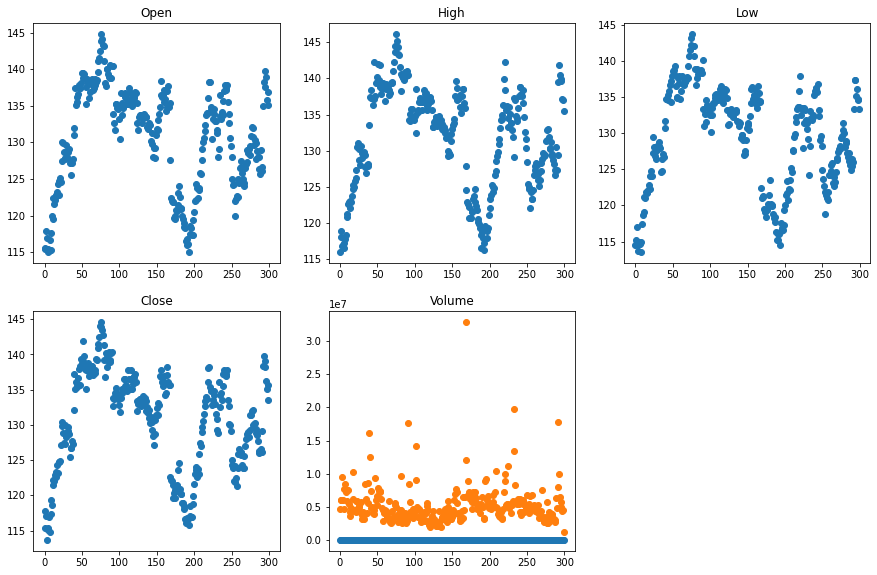

In [164]:
#Checking for outliers using scatter plot

plt.figure(figsize = (15,15))

plt.subplot(3,3,1)
plt.scatter(data.index, data.OPEN)
plt.title('Open')

plt.subplot(3,3,2)
plt.scatter(data.index, data.HIGH)
plt.title('High')

plt.subplot(3,3,3)
plt.scatter(data.index, data.LOW)
plt.title('Low')

plt.subplot(3,3,4)
plt.scatter(data.index, data.CLOSE)
plt.title('Close')

plt.subplot(3,3,5)
plt.scatter(data.index, data.ADJCLOSE)
plt.title('Adj Close')

plt.subplot(3,3,5)
plt.scatter(data.index, data.VOLUME)
plt.title('Volume')

plt.show()

C:\Users\Thandiwe\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


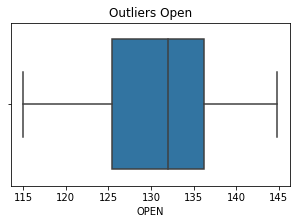

C:\Users\Thandiwe\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


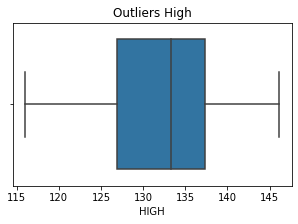

C:\Users\Thandiwe\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


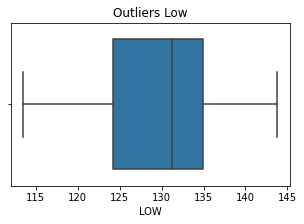

C:\Users\Thandiwe\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


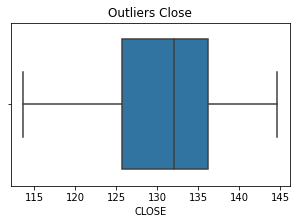

C:\Users\Thandiwe\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


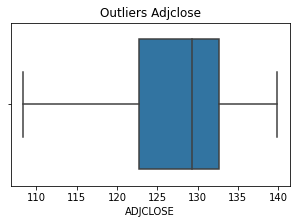

C:\Users\Thandiwe\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


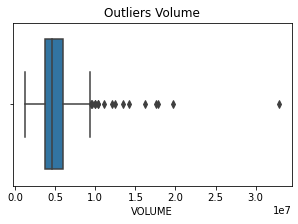

In [165]:
#Checking for outliers using boxplot 
sns.boxplot(data['OPEN'])
plt.title('Outliers Open')
plt.show()
sns.boxplot(data['HIGH'])
plt.title('Outliers High')
plt.show()
sns.boxplot(data['LOW'])
plt.title('Outliers Low')
plt.show()
sns.boxplot(data['CLOSE'])
plt.title('Outliers Close')
plt.show()
sns.boxplot(data['ADJCLOSE'])
plt.title('Outliers Adjclose')
plt.show()
sns.boxplot(data['VOLUME'])
plt.title('Outliers Volume')
plt.show()

<AxesSubplot:>

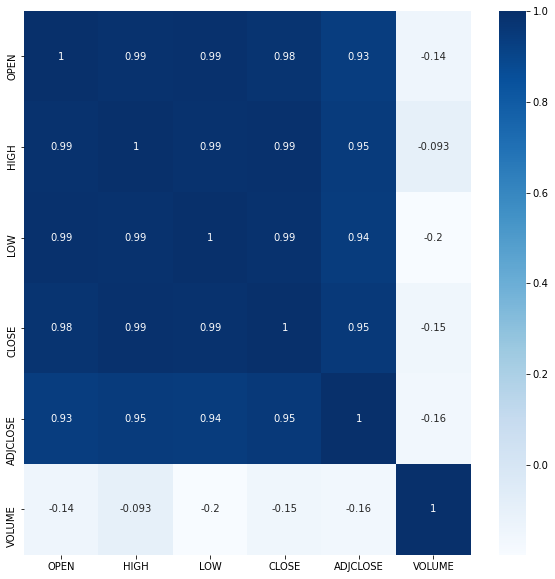

In [76]:
#Checking for correlation in the numerical values
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),cbar=True,annot=True,cmap='Blues')

From the above heatmap we notice that all the five coloumns(Open,High,Low,Close,AdjClose),
Have a high correlation

## PCA to Speed-up Machine Learning Algorithms

In [166]:
from sklearn.preprocessing import StandardScaler
# Separating out the features
x = data.drop(labels=['DATE','TICKER','VOLUME'], axis=1).values

In [167]:
# performing preprocessing part
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x=sc.fit_transform(x)

In [187]:
# Applying PCA function on X component
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

x=pca.fit_transform(x)
Pdf = pd.DataFrame(data = x , columns = ['pcomponent1', 'pcomponent2'])

explained_variance = pca.explained_variance_ratio_


In [188]:
explained_variance

array([0.98293777, 0.01706223])

The explained variance tells us how much information (variance) can be attributed to each of the principal components.
This is important as while you can convert 4 dimensional space to 2 dimensional space, you lose some of the variance 
(information) when you do this. By using the attribute explained_variance_ratio_, you can see that the first principal
component contains 97.6% of the variance and the second principal component contains 1.6% of the variance. 
Together, the two components contain 99.20% of the information.

In [189]:
Pdf.head()

,pcomponent1,pcomponent2
0,5.065155,-0.420851
1,4.594319,-0.221516
2,4.360740,-0.509444
3,5.199271,-0.661005
4,5.032688,-0.417632


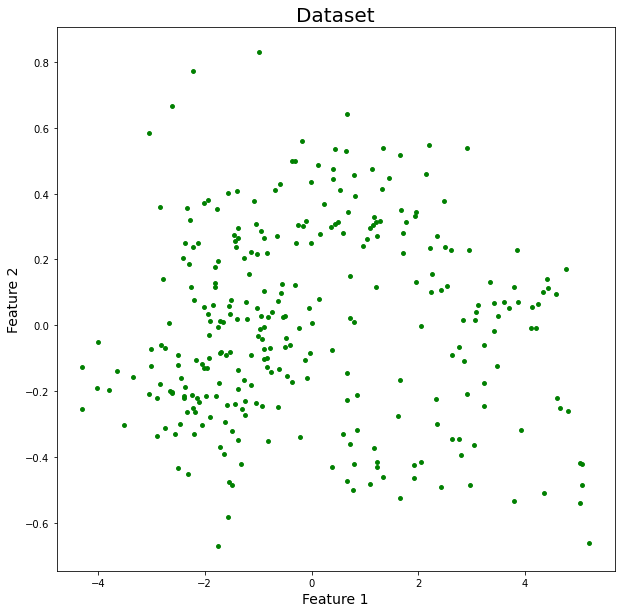

In [190]:
#ploting the new coloumns we got after applying PCA
plt.figure(figsize=(10,10))
plt.scatter(Pdf['pcomponent1'],Pdf['pcomponent2'],s=15,color='green')
plt.title('Dataset',fontsize=20)
plt.xlabel('Feature 1',fontsize=14)
plt.ylabel('Feature 2',fontsize=14)
plt.show()


## Elbow Method for optimal value of k in KMeans

### Importing the required libraries

In [175]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

### Building the clustering model and calculating the values of the Distortion and Inertia:
Distortion: It is calculated as the average of the squared distances from the cluster centers 
of the respective clusters. Typically, the Euclidean distance metric is used.
Inertia: It is the sum of squared distances of samples to their closest cluster center.
We iterate the values of k from 1 to 9 and calculate the values of distortions for each value of k 
and calculate the distortion and inertia for each value of k in the given range.

In [176]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(x)
    kmeanModel.fit(x)
 
    distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / x.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(x, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / x.shape[0]
    mapping2[k] = kmeanModel.inertia_

C:\Users\Thandiwe\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Thandiwe\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "


### Tabulating and Visualizing the results
Using the different values of Distortion:

In [177]:
for key, val in mapping1.items():
    print(f'{key} : {val}')


1 : 1.9002171353191017
2 : 1.0028612234569496
3 : 0.7405278761598378
4 : 0.6029019962943477
5 : 0.5195660013175357
6 : 0.4573371390187676
7 : 0.4271371176608901
8 : 0.3903184898363214
9 : 0.35978813337217425


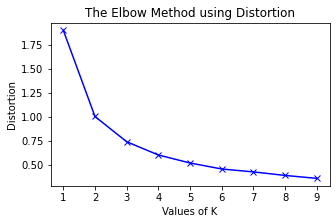

In [178]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()


Using the different values of Inertia:

In [179]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 1490.163040929864
2 : 419.02966889109115
3 : 218.78760150158828
4 : 141.95151234026463
5 : 101.19782183616476
6 : 77.41810009838323
7 : 65.89407720488592
8 : 54.06791340721562
9 : 46.76462486061331


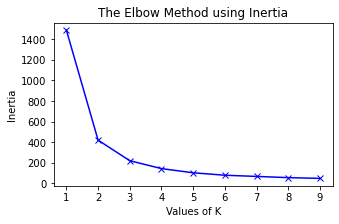

In [180]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie 
the point after which the distortion/inertia start decreasing in a linear fashion. Thus for the given data, 
we conclude that the optimal number of clusters for the data is 2.

In [181]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=0).fit(x)
kmeans.labels_  # same as kmeans.predict(df)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [182]:
kmeans.inertia_

419.02966889109115

In [183]:
kmeans.n_iter_

6

In [184]:
kmeans.cluster_centers_

array([[ 2.39660995, -0.00440457],
       [-1.48978456,  0.00273797]])

In [185]:
from collections import Counter
Counter(kmeans.labels_)

Counter({0: 115, 1: 185})

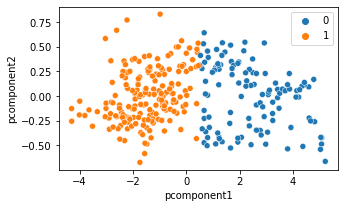

In [186]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=Pdf, x="pcomponent1", y="pcomponent2", hue=kmeans.labels_)
plt.show() 